<a id="presentation"></a>
#  Презентация

* [Презентация](https://drive.google.com/file/d/1ofpxUx0YIGwfjOTp-jBnAVzVn2b2ZcW_/view?usp=sharing)

# Оглавление:
1. [Презентация](#presentation) 
2. [Описание проекта](#description)
3. [Описание данных](#data)
4. [Загрузка данных и подготовка их к анализу](#start)
5. [Анализ данных](#preprocessing)
    * [Исследование соотношения видов объектов общественного питания по количеству и постороенние графика](#number_of_cafes)
    * [Исследвание соотношеня сетевых и несетевых заведений по количеству и построение графика](#chain)
    * [Для какого вида объекта общественного питания характерно сетевое распространение?](#object_type_chain)
    * [Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?](#number)
    * [Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.](#object_type_number)
    * [Выделяем в отдельный столбец информацию об улице из столбца address](#address)
    * [Построение графика топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?](#top10_street)
    * [Находим число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?](#one_id_streets)
    * [Изучение распределения количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?](#heatmap)
6. [Выводы и рекомендации](#conclusion)

# Описание проекта

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

# Описание данных

Таблица data:
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

<a id="start"></a>
#  Загрузка данных и подготовка их к анализу

Загружаем данные о заведениях общественного питания Москвы. Проверем, что тип данных в каждой колонке — правильный, а также отсутствуют пропущенные значения и дубликаты. При необходимости обработаем их.

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import requests

In [2]:
# создаем таблицу 'data' и вызываем первые пять строк таблицы
data = pd.read_csv('/datasets/rest_data.csv')
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
# запрашиваем информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Как мы видим, с типом данных в датасете все хорошо - значения числового типа имеют тип данных int, а не численные значения - тип object. Кроме того, в датасете отсутствуют пропуски.

    Непрямые дубликаты

Проверим, есть и в столбцах уникальные значения при помощи метода unique(). Имеет смысл проверить на наличие таких дубликатов только столбец `object_type`, т.к. в нем мы сможем найти опечатку. 

In [4]:
# просмотр уникальных названий типов заведений
data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Так же переведем названия наших заведений в нижний регистр.

In [5]:
# приводим столбец к нижнему регистру
data['object_name'] = data['object_name'].str.lower()

    Прямые дубликаты

Однако, чтоб работать с нашими данными, надо еще проверить их на наличие дубликатов, что мы дальше и будем делать. Поскольку идентификатор объекта уникален, то нет смысла проверять всю таблицу на наличие дубликатов. Проверим тогда лишь некоторые столбцы, такие как `object_name` и `address`.

In [6]:
# проверяем на наличие дубликатов столбец object_name
data['object_name'].duplicated().sum()

5442

Как видим, у нас много прямых дубликатов. Посмотрим на топ-10 наиболее встречающихся названия объекта общественного питания при помощи метода value_counts().

In [7]:
# выводим топ-10 наиболее встречающихся дубликатов на экран
data['object_name'].value_counts().head(10)

столовая           321
кафе               278
шаурма             250
шоколадница        158
kfc                155
макдоналдс         151
бургер кинг        137
теремок             94
крошка картошка     90
домино'с пицца      90
Name: object_name, dtype: int64

Как мы видим, повторяются у нас названия общеизвестных сетевых заведений - kfc, теремок, шоколадница и др.Кроме того, не является редкостью название небольших несетевых заведений - кафе, столовая, шаурма. 

Таким образом, такие дубликаты не стоить как-либо менять или удалять, ведь так мы потеряем большую часть данных, что естественным образом скажется на результатах нашего исследования.


Теперь обратим внимание на столбец `address` и проделаем все те же манипуляции с нашими данными.

In [8]:
# проверяем на наличие дубликатов столбец address
data['address'].duplicated().sum()

6258

Аналогично много прямых дубликатов. Изучим их повнимательнее.

In [9]:
# выводим топ-10 наиболее встречающихся дубликатов на экран
data['address'].value_counts().head(10)

город Москва, Ходынский бульвар, дом 4            95
город Москва, Пресненская набережная, дом 2       63
город Москва, проспект Мира, дом 211, корпус 2    60
город Москва, Кировоградская улица, дом 13А       53
город Москва, площадь Киевского Вокзала, дом 2    48
город Москва, улица Земляной Вал, дом 33          46
город Москва, Мытная улица, дом 74                46
город Москва, улица Новый Арбат, дом 21           42
город Москва, улица Ленинская Слобода, дом 26     41
город Москва, Ярцевская улица, дом 19             40
Name: address, dtype: int64

Используя интернет можно с легкостью узнать, что по данным адресам находятся торгово-развлекательные центры. Например, наш лидер по количеству заведений,  Ходынский бульвар, дом 4 - это адрес ТРЦ Авиапарк, следующий адрес - Пресненская набережная, дом 2  - ТРЦ  Афимол. Проспект Мира, дом 211, корпус 2 - адрес ТРЦ Европолис. Естественно, что данные адреса встречаются не по одному разу: в торговых центрах зачастую есть большое количество заведений общественного питания.

В связи с этим, не стоит вносить изменения в этото столбец, чтоб не получить неточности в дальнейших расчетах.

**ВЫВОД**

При обработке данных мы заменили все данные на нижний регистр. При проверки данных на прямые и не прямые дубликаты не было найдено никаких ошибок. Теперь данные готовы к анализу.

<a id="preprocessing"></a>
# Анализ данных

<a id="number_of_cafes"></a>
##### Исследуем соотношение видов объектов общественного питания по количеству и построим график.

Для данного исследования мы применим value_counts() к столбцу `object_type`, для того, чтоб узнать количество уникальных совпадений в этой колонке. Затем вернем не Series, а DataFrame, для последующего использования этих данных в построении гистограммы.

После построим столбчатую гистограмму для большей наглядности на основе нашего дата фрейма.

In [10]:
# применяем метод value_counts() 
value_counts = data['object_type'].value_counts()
df_value_counts = pd.DataFrame(value_counts)
# сбросим индексы методом reset_index()
df_value_counts = df_value_counts.reset_index()
df_value_counts

,index,object_type
0,кафе,6099
1,столовая,2587
2,ресторан,2285
3,предприятие быстрого обслуживания,1923
4,бар,856
5,буфет,585
6,кафетерий,398
7,закусочная,360
8,магазин (отдел кулинарии),273


Теперь строим столбчатую диаграмму.

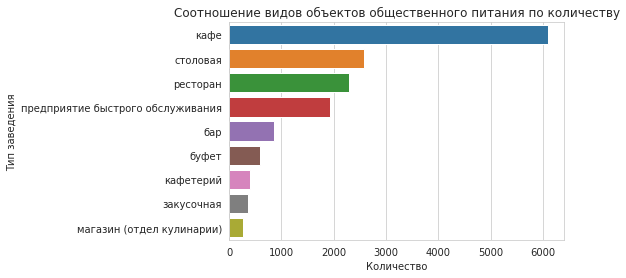

In [11]:
# устанавливаем стиль 'whitegrid' для нашей гистограммы
sns.set_style("whitegrid")
# устанавливаем заголовок гистограммы
plt.title('Cоотношение видов объектов общественного питания по количеству')
# строим гистограмму методом barplot()
sns.barplot(x='object_type', y='index', data=df_value_counts)
# задаем название осям нашей гистограммы 
plt.xlabel("Количество")
plt.ylabel("Тип заведения")
plt.show()

Лидирующим типом заведений является:
 * кафе (6 тыс. заведений);
 * почти вровень столовые и рестораны (около 2.5 тыс. заведений);
 * cамые малочисленные заведения в Москве - кафетерии, закусочные и отдел кулинарии в магазине (до 400 заведений).

<a id="chain"></a>
##### Исследуем соотношение сетевых и несетевых заведений по количеству и строим график.

Проведем анализ в соответствии с предыдущим  пунктом, но за основу уже возьмем столбец `chain`.

In [12]:
# применяем метод value_counts()
value_counts = data['chain'].value_counts()
df_value_counts = pd.DataFrame(value_counts)
# сбросим индексы методом reset_index()
df_value_counts = df_value_counts.reset_index()
df_value_counts

,index,chain
0,нет,12398
1,да,2968


Теперь строим график.

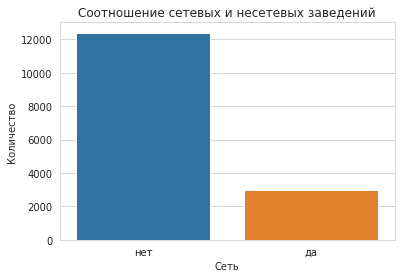

In [13]:
# устанавливаем стиль 'whitegrid' для нашей гистограммы
sns.set_style("whitegrid")
# устанавливаем заголовок гистограммы
plt.title('Соотношение сетевых и несетевых заведений')
# строим гистограмму методом barplot()
sns.barplot(x='index', y='chain', data=df_value_counts)
# задаем название осей нашей гистограммы
plt.xlabel("Сеть")
plt.ylabel("Количество")
plt.show()

Как мы видим, в Москве преимущественно находятся несетевые заведения. И лишь 19 % заведений имеют сеть. 

<a id="object_type_chain"></a>
##### Для какого вида объекта общественного питания характерно сетевое распространение?


Создадим переменную `chain_company`, в которой будут только  данные с заведениями сетевого типа. Для этого сделаем срез нашего датасета при помощи метода query().

Затем создадим сводную таблицу  со столбцами, в которых отразим количество разных типов заведения, а также соотношение их к общему количеству по типу заведения. Следственно, найдя относительную, а не абсолютную величину, мы не исказим наши итоговые значения, а, напротив, дадим наиболее объективную картину происходящего.

In [14]:
# создаем переменную chain_company
chain_company = data.query('chain == "да"')
# создаем сводную таблицу
chain_company = (
    chain_company.pivot_table(index='object_type',
                              values='id',
                              aggfunc='count')
) 
# создаем столбец total, в котором соханяем количество сетевых заведений всего
chain_company['total'] = data['object_type'].value_counts()
# создаем столбец ratio с нашим относительным значением
chain_company['ratio'] = chain_company['id'] / chain_company['total']
# фильтруем данные по убыванию столбца ratio
chain_company = chain_company.sort_values('ratio', ascending=False)
# обновляем наши индексы методом reset_index()
chain_company = chain_company.reset_index()
chain_company

,object_type,id,total,ratio
0,предприятие быстрого обслуживания,791,1923,0.411336
1,магазин (отдел кулинарии),78,273,0.285714
2,ресторан,544,2285,0.238074
3,кафе,1396,6099,0.228890
4,закусочная,56,360,0.155556
5,кафетерий,52,398,0.130653
6,бар,37,856,0.043224
7,буфет,11,585,0.018803
8,столовая,3,2587,0.001160


Построим гистограмму по новым данным.

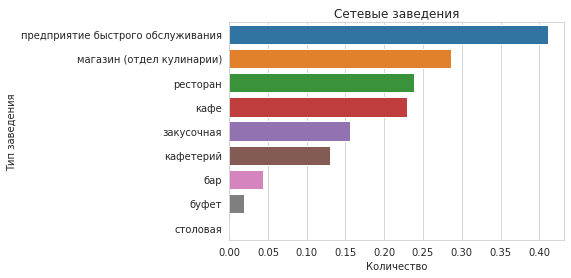

In [15]:
# устанавливаем заголовок гистограммы
plt.title('Сетевые заведения')
# строим гистограмму методом barplot()
sns.barplot(x='ratio', y='object_type', data=chain_company)
# задаем название осей нашей гистограммы
plt.xlabel("Количество")
plt.ylabel("Тип заведения")
plt.show()

Из данных сводной таблицы видно:
 * больше всего в Москве сетевого типа предприятий быстрого обслуживания (41%);
 * затем идут предприятия отдела кулинарии (28%) и рестораны(24%);
 * сетевых кафе у нас лишь 23 %, что говорит нам о том, что кафе несетевого типа более популярны. 

Остальные типы заведений предпочитают не особо предпочитают сетевое распространение. Наименьше всего в городе столовых сетевого типа(0.1%).

<a id="number"></a>
##### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Для начала нужно определить, какие могут быть типы зависимостей.Выделим четыре группы:
 * Много мест — много заведений;
 * Много мест — мало заведений;
 * Мало мест — много заведений;
 * Мало мест —  мало заведений.
    
Делаем срез данных,  в которых будут лишь сетевые заведения и сохраняем в переменную `new_chain_company`.

Затем группируем данные по названию объекта и применим агрегирующие функции к персональному номеру и количеству мест. Персональные номера мы посчитаем, а у мест найдем среднее.

Затем построим график корреляции, который покажет нам зависимость одного показателя от другого.

In [16]:
# делаем срез данных при помощи метода query() 
new_chain_company = data.query('chain == "да"')
# группируем данные по типу заведения и применяем к ним агрегирующую функцию
new_chain_company = new_chain_company.groupby('object_name').agg({'id':'count','number':'mean' })
# переименовываем наши столбцы
new_chain_company = (
    new_chain_company
    .rename(columns={'id':'number of catering establishments','number':'number of seats'})
)
# группируем таблицу по количеству мест
display(new_chain_company.sort_values(by='number of seats',ascending=False).head())
# группируем таблицу по количеству зааведений в сети
display(new_chain_company.sort_values(by='number of catering establishments',ascending=False).head())

,number of catering establishments,number of seats
object_name,,
чешская пивная «козловица»,1,306.0
кафе му-му,1,300.0
ян примус,1,300.0
якитория и ян примус,1,282.0
старина миллер,1,280.0


,number of catering establishments,number of seats
object_name,,
шоколадница,157,57.184713
kfc,155,55.341935
макдоналдс,151,87.119205
бургер кинг,137,46.649635
теремок,94,25.606383


Cтроим диаграмму рассеивания на основе нового датасета.

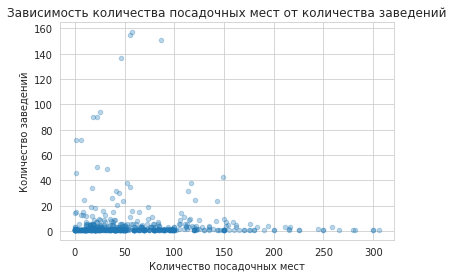

In [17]:
# строим диаграмму рассеивания на основе нового датасета
new_chain_company.plot(
    x='number of seats',
    y='number of catering establishments',
    kind='scatter',
    alpha=0.3)
# устанавливаем заголовок диаграммы
plt.title('Зависимость количества посадочных мест от количества заведений')
# задаем название осей нашей диаграммы
plt.xlabel('Количество посадочных мест')
plt.ylabel('Количество заведений')
plt.show()

Согласно графику никакой корреляции между количеством посадочных мест и количеством заведений нет. 

Так, в среднем, если обратить внимание на график и на таблицу, наибольшее количество посадочных мест рассчитывается в `чешская пивная «козловица»`, в сети которой находится лишь один ресторан.
Таким образом, **предположение чем меньше заведений, тем меньше мест, является ложным**. 

С другой стороны, лидер по количеству заведений `шоколадница`, представленная в 157 заведений, располагает, в среднем, лишь 57 столиками. Поэтому **зависимость между большим количеством заведений и таким же большим количеством посадочных мест не наблюдается**. 

**Зависимость мало заведений - много мест так же не наблюдается**. В кафе `милано пицца`, представленное лишь 1 раз  количество мест всего лишь 20. 

**Последняя возможная зависимость - много заведений - мало мест так же является ложной**. Так, рассмотрев пример ресторана `макдональдс`, который является третьим по количеству заведений (151 заведение), мы видим, что количество посадочных мест равно 87.


На этом можно сделать вывод, что у нас отсутствует какая-либо зависимость между количеством мест и количеством заведений в сети.


<a id="object_type_number"></a>
##### Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

Мы создадим сводную таблицу `seat_company`, которая отразит вид объекта общественного питания и среднее количество посадочных мест. Затем построим график и сделаем выводы.

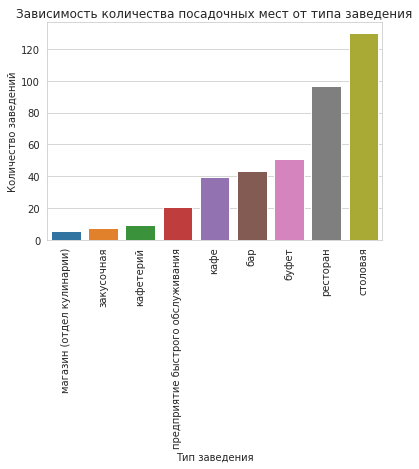

In [18]:
# создаем сводную таблицу
seat_company = data.pivot_table(index='object_type', values='number')
seat_company = seat_company.reset_index().sort_values('number')
seat_company
# строим график
sns.barplot(x='object_type', y='number',data=seat_company)
# устанавливаем заголовок гистограммы
plt.title('Зависимость количества посадочных мест от типа заведения')
# поварачиваем подписи на оси-х на 90 градусов
plt.xticks(rotation=90)
# задаем название осей нашего графика
plt.xlabel('Тип заведения')
plt.ylabel('Количество заведений')
plt.show()

Из графика мы можем сделать вывод:
 * самое большое среднее количество посадочных мест нам предлагают столовые - около 130;
 * затем рестораны - они предлагают в среднем 96 мест. 

Связано это, скорее всего, с тем, что в столовых, при небольших ценах, можно полноценно пообедать, чем активно пользуются люди, которые работают неподалеку, ходящие на обеденный перерыв подкрепиться. Поэтому, чтоб поместить всех желающих в этот обеденный перерыв и сделать хорошую выручку на этом, столовые заинтересованы в большом количестве мест.

В рестораны же люди часто приходят за атмосферой, чтоб насладится хорошей едой, красивым пространством  и сервисом. И все это уже заложено уже в стоимость блюда, поэтому люди редко берут на вынос, а скорее отдыхают в самом заведении.

<a id="address"></a>
##### Выделим в отдельный столбец информацию об улице из столбца address

Для того, чтоб выделить в отдельный столбец информацию об улице применим к столбцу `address` метод apply(lambda x:x.split), чтоб разделить наш столбец на новый. Поскольку город от улицы и номера дома отделяет запятая, то её мы и укажем в качестве аргумента. Улица занимает второе положение в столбце, поэтому мы укажем индекс элемента [1].

In [19]:
# создаем столбец street с названием улицы
data['street'] = data['address'].apply(lambda x:x.split(',')[1])

<a id="top10_street"></a>
##### Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Построим сводную таблицу `top_10`, в котором отразим улицы и количество заведений на них при помощи агрегирующей функции count(). 

На основании полученных данных построим график. 

Затем загрузим классификатор улиц Москвы, и посмотрим на каких районах находятся наши улицы.
На основании наших расчетов построим график.

In [20]:
# создаем сводную таблицу в переменной top_10
top_10 = data.pivot_table(index='street', values='object_name',
                          aggfunc='count')
# переименовымаем столбец методом columns()
top_10.columns = ['number of catering facilities']
# фильтруем данные по убыванию
top_10 = top_10.sort_values('number of catering facilities', ascending=False).head(10)
# сбрасываем индексы
top_10 = top_10.reset_index()
top_10

,street,number of catering facilities
0,город Зеленоград,232
1,проспект Мира,204
2,Профсоюзная улица,182
3,Ленинградский проспект,171
4,Пресненская набережная,167
5,Варшавское шоссе,161
6,Ленинский проспект,147
7,поселение Сосенское,138
8,проспект Вернадского,132
9,Кутузовский проспект,114


Строим график.

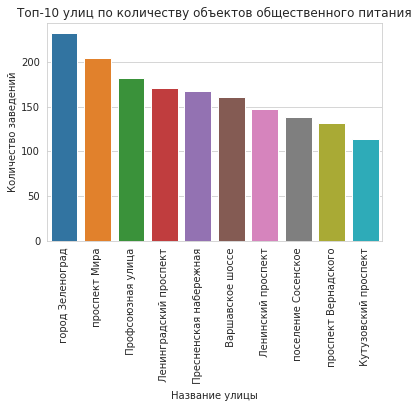

In [21]:
# строим гистограмму методом barplot()
sns.barplot(x='street', y='number of catering facilities', data=top_10)
# устанавливаем заголовок гистограммы
plt.title('Топ-10 улиц по количеству объектов общественного питания')
# задаем название осей нашей гистограммы
plt.xlabel("Название улицы")
# поварачиваем подписи на оси-х на 90 градусов
plt.xticks(rotation=90)
plt.ylabel("Количество заведений")
plt.show()

По количеству общепита в Москва лидирует:
 * Зеленоград - 232 заведения;
 * Затем идет проспект Мира и Профсоюзная улица. 

Теперь загрузим таблицу `mos_district`, которая покажет нам район, в котором находятся наши десять самый популярных улиц. После объединим наши две таблицы и найдем топ-10 районов.

In [22]:
# загружаем нашу таблицу и даем ей имя mos_district
spreadsheet_id = '1kqYTjvBcn-ArBMdg3b4sPAkIFUyndBVu6WKZKovKodQ'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
mos_district = pd.read_csv(BytesIO(r.content))
# меняем название столбца в таблице методом rename()
mos_district = mos_district.rename(columns={'streetname':'street'})
mos_district.head()

,street,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


Теперь объединим наши две таблицы, чтоб узнать каким районам соответствуют наш топ-10. У данных таблиц мы видим общий столбец `street`, по которому мы и будем соединять наши таблицы в одну методом merge().

Перед этим мы уберем лишние пробелы в наших столбцах методом str.strip()

In [23]:
# убираем лишние пробелы в наших таблицах методом str.strip()
top_10['street'] = top_10['street'].str.strip()
mos_district['street'] = mos_district['street'].str.strip()

Теперь можем объединять наши таблицы по общему столбцу.

In [24]:
# объединяем наши таблицы 
street_district =  top_10.merge(mos_district, on='street', how='left')
# группируем таблицу по району и применяем агрегирующие функции
# к столбцу с улицей и количеством заведений
street_district = (
    street_district.groupby('area')
    .agg({'street':'count', 'number of catering facilities':'sum'})
)
# фильтруем наш получившийся датафрейм по количеству заведеий
street_district = (
    street_district
    .sort_values('number of catering facilities', ascending=False)
    .head(10)
)
street_district = street_district.reset_index()
street_district

,area,street,number of catering facilities
0,Обручевский район,2,329
1,Район Теплый Стан,2,329
2,Донской район,2,308
3,Ломоносовский район,2,279
4,Район Проспект Вернадского,2,279
5,Район Тропарево-Никулино,2,279
6,Район Гагаринский,2,279
7,Район Матушкино-Савелки,1,232
8,Район Крюково,1,232
9,Панфиловский район,1,232


Теперь строим гистограмму.

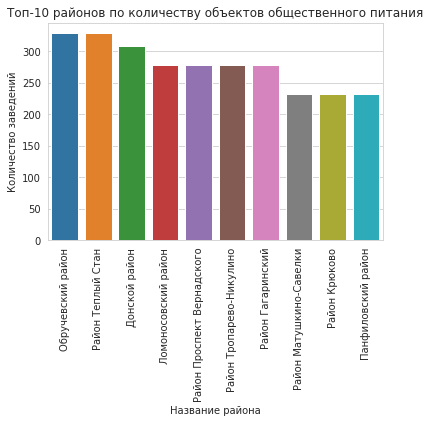

In [25]:
# строим гистограмму методом barplot()
sns.barplot(x='area', y='number of catering facilities', data=street_district)
# устанавливаем заголовок гистограммы
plt.title('Топ-10 районов по количеству объектов общественного питания')
# поварачиваем подписи на оси-х на 90 градусов
plt.xticks(rotation=90)
# задаем название осей нашей гистограммы
plt.xlabel("Название района")
plt.ylabel("Количество заведений")
plt.show()

Как мы видим по таблице и гистограмме, самые **популярные районы для общественного питания это Обручевский район и Теплый Стан**, которые находятся на юго-западе столицы. Популярность этих улиц связана с тем, что они длинные, и, соответственно, довольно большое число заведений на них находятся вследствии значительного размера самих улиц.  

<a id="one_id_streets"></a>
##### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Для того, чтоб найти число улиц с одним объектом общественного питания нужно сгруппировать данные по улице и посчитать количество объектов. Сохраним эти данные в переменную `one_in_street`.

Затем перевести структуру данных Series в DataFrame методом to_frame() и "обновить" индексы методом reset_index(). После данной операции мы отфильтровать только те данные, где количество объектов равно единице при помощи lambda.После считаем количество получившихся строк методом len(). 


Как и в предыдущем пункте, объединим получившуюся таблицу с загруженной ранее таблицей `mos_district` и отсортируем ее по району, а затем построим гистограмму.

In [26]:
# создаем переменную one_in_street
one_in_street = (
    data.groupby('street')['id'].count()
    .to_frame()
    .reset_index()
    .loc[lambda x:x['id'] == 1]           
)    
len(one_in_street)

579

Как видно из наших вычислений, количество улиц с одним обьектом общественного питания равно 579.

Теперь объединим наши две таблицы, чтоб узнать каким районам соответствуют улицы с одним обьектом общественного. У данных таблиц мы видим общий столбец `street`, по которому мы и будем соединять наши таблицы в одну методом merge().

Перед этим мы уберем лишние пробелы в наших столбцах методом str.strip()

In [27]:
# убираем лишние пробелы в столбце
one_in_street['street'] = one_in_street['street'].str.strip()

Объединяем наши данные в таблицу `min_district`.

In [28]:
# создаем таблицу min_district
min_district =  one_in_street.merge(mos_district, on='street', how='left')
# группируем таблицу по району и применяем агрегирующие функции
# к столбцу с улицей и количеством заведений
min_district = (
    min_district.groupby('area')
    .agg({'street':'count', 'id':'sum'})
)
# фильтруем наш получившийся датафрейм по количеству заведеий
min_district = min_district.sort_values('id', ascending=False)
min_district = min_district.reset_index()
min_district.head()                       

,area,street,id
0,Таганский район,27,27
1,Район Хамовники,26,26
2,Басманный район,25,25
3,Тверской район,20,20
4,Пресненский район,19,19


Строим по нашим данным график.

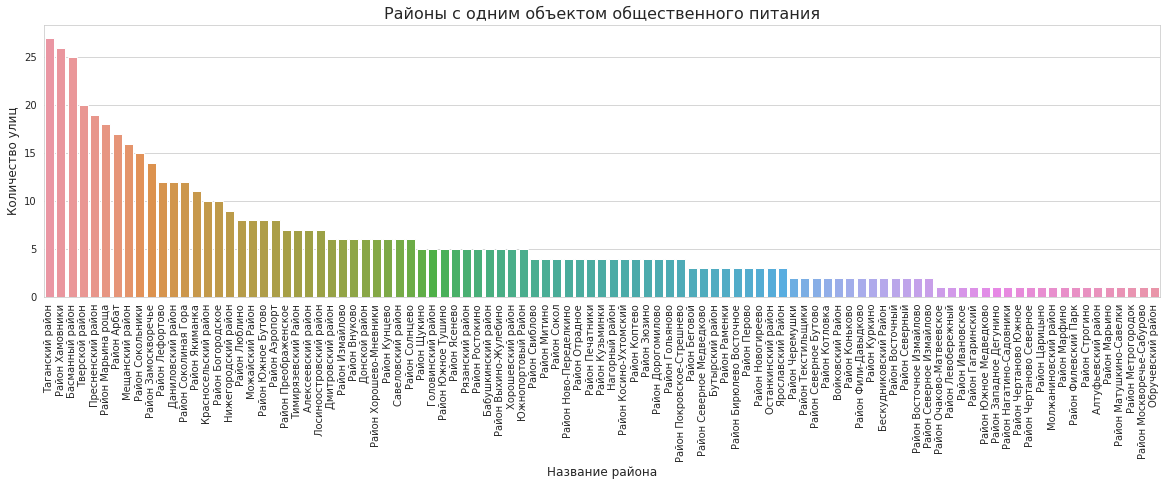

In [29]:
#  устанавливаем размер нашей гистограммы
plt.figure(figsize=(20,5))
#задаем заголовок гистограммы и его размер
plt.title('Районы с одним объектом общественного питания', fontsize = 16)
# строим гистограмму методом barplot()
sns.barplot(x='area', y='street', data=min_district)
# поварачиваем подписи на оси-х на 90 градусов
plt.xticks(rotation=90)
# задаем название осей нашей гистограммы
plt.xlabel("Название района", fontsize = 12)
plt.ylabel("Количество улиц", fontsize = 12)
plt.show()

Из нашей гистограммы и сгруппированных данных можно сделать вывод, что **больше всего улиц с одним заведений в Москве в Таганском районе, Хамовниках и Басманном районе**. Это дорогие улицы в историческом центре Москвы с центрами современного искусства, дорогими брами и высокой кухней. 

Полагаю, что на этих улицах располагается лишь одно заведение, поскольку не все заведения могут позволить себе такую дорогую аренду помещения в самом сердце Москвы.Также улицы в центре меньше и на них просто не поместится большое число заведений.

Всего в Мосвке 99 районов с улицами на которых одно заведение общественного питания.

<a id="heatmap"></a>
##### Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

Объединим наш изначальный датасет с датасетом `top_10`, в котором у нас находятся самые популярные для общепита улицы. Получившийся датасет назовем `top_10_street`.

Затем создадим сводную таблицу , где столбцу `columns` передадим значение object_type, а значение `number`, которое мы подсчитаем методом count(). Таким образом, мы увидим, количество  посадочных мест в зависимости от типа заведения на каждой из популярной улицы.

После, создадим тепловую карту на основе данных и выявим закономерности.

Перед начало объединения даасетов убираем лишние пробелы в столбце `street`.

In [30]:
# убираем лишние пробелы в столбце
data['street'] = data['street'].str.strip()

Теперь объединяем две таблицы. Пропуски заполним нулями.

In [31]:
# объединяем две таблицы методом merge() в top_10_street
top_10_street = top_10.merge(data, on='street', how='left')
# создаем сводную таблицу при помощи метода pivot_table()
top_10_street = (
    top_10_street.pivot_table
    (index = 'object_type',
     columns = 'street',
     values='number',
     aggfunc='count')
)
# заполнем наши пропуски нулями
top_10_street.fillna('0')

street,Варшавское шоссе,Кутузовский проспект,Ленинградский проспект,Ленинский проспект,Пресненская набережная,Профсоюзная улица,город Зеленоград,поселение Сосенское,проспект Вернадского,проспект Мира
object_type,,,,,,,,,,
бар,6.0,6.0,10.0,6.0,5.0,5.0,10.0,8.0,4.0,15.0
буфет,6.0,1.0,6.0,1.0,1.0,5.0,4.0,0,5.0,3.0
закусочная,2.0,2.0,0,1.0,0,2.0,0,16.0,2.0,4.0
кафе,63.0,41.0,70.0,64.0,98.0,90.0,68.0,92.0,56.0,103.0
кафетерий,8.0,0,3.0,3.0,5.0,10.0,21.0,1.0,3.0,5.0
магазин (отдел кулинарии),2.0,2.0,5.0,0,0,2.0,1.0,0,2.0,8.0
предприятие быстрого обслуживания,40.0,8.0,16.0,9.0,18.0,23.0,26.0,3.0,27.0,26.0
ресторан,9.0,48.0,48.0,37.0,40.0,31.0,15.0,15.0,19.0,32.0
столовая,25.0,6.0,13.0,26.0,0,14.0,87.0,3.0,14.0,8.0


Строим тепловую карту.

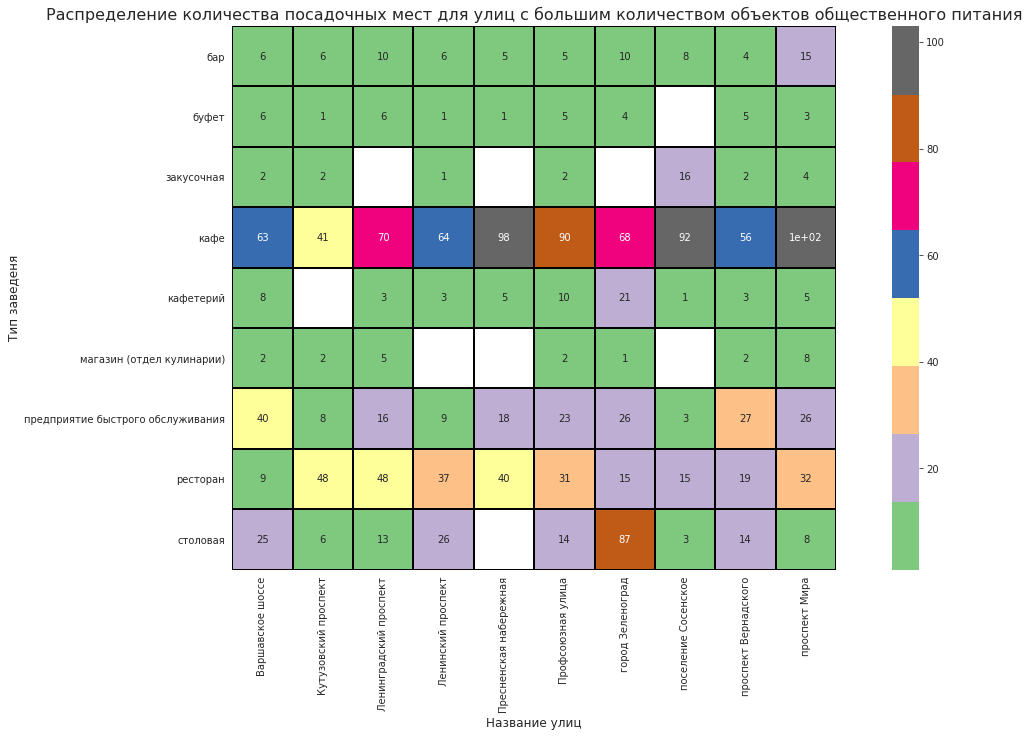

In [32]:
# устанавливаем размер нашей тепловой карте
plt.figure(figsize=(20,10))
# задаем заголовок и размер нашей таблицы
plt.title('Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания',
        fontsize = 16)
# строим тепловую карту методом heatmap()
sns.heatmap(top_10_street,
            annot = True, 
            cmap = 'Accent',
            linewidths=1,
            linecolor='black',
            square=True)
# задаем название осей нашей гистограммы
plt.xlabel("Название улиц", fontsize = 12)
plt.ylabel("Тип заведеня", fontsize = 12)
plt.show()

Закономерномерности:
 * наибольшее количество посадочных мест у нас находятся в кафе и ресторанах;
 * по большей части заведения имеют небольшое количество посадочных мест (меньше 10), что говорит о том, что люди в заведениях не задерживаются, а берут еду и напитки с собой.

<a id="conclusion"></a>
# Выводы и рекомендации

**ВЫВОДЫ**

    1. Тип заведения

Лидирующим типом заведений является:
 * кафе (6 тыс. заведений)
 * далее с огромным перевесом идут почти вровень столовые и рестораны (около 2.5 тыс. заведений)
 * самыми малочисленными заведениями в Москве являются кафетерии, закусочные и отдел кулинарии в магазине (около 400 заведений).
 
Лишь 19 % заведений от общего числа имеют сеть, остальные представлены в единственном числе.

    2. Посадочные места

Наибольшее количество посадочных мест находятся в кафе и ресторанах (от 41 до 103).

По большей свой части заведения имеют небольшое количество посадочных мест (меньше 10), что говорит о том, что люди в заведениях не задерживаются, а берут еду с собой.

    3. Расположение

В ходе нашего исследования мы нашли самые популярные для общепита адеса и это:
 * город Зеленоград;
 * проспект Мира;
 * Профсоюзная улица;
 * Ленинградский проспект;
 * Пресненская набережная;
 * Варшавское шоссе;
 * Ленинский проспект;
 * поселение Сосенское;
 * проспект Вернадского;
 * Кутузовский проспект. 
 
Больше всего улиц с одним заведений в Москве в Таганском районе, Хамовниках и Басманном районе.

Всего в Москве 99 районов с улицами на которых одно заведение общественного питания.

Самые популярные районы для общественного питания это Обручевский район и Теплый Стан, которые находятся на юго-западе столицы.
 


**РЕКОМЕНДАЦИИ**

В ходе исследования, мы выявили, что наиболее перспективной идеей будет открытие несетевого кафе, находящейся в Обручевский районе или Теплом Стане. Количество посадочных мест варьируется от 41 до 103.